# Housing prices in California

## Author

Jose Juan Pena Gomez

## Introduction

This project is about building a machine learning model which predicts housing prices in California using the California census data.


## Set up the project libraries

In this project we are going to use several tools as **Numpy** for mathematicals issues, **Pandas** for arrange the data, **sklearn** for the ML part and **matplotlib** for plotting the results. Is also used **tarfile** and **six** for importing the housing prices in California.

In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer as Imputer

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

In [2]:
%matplotlib inline

# Get the data

For getting the data is necesary to first download the dataset from the webpage written below and saved in a variable.
Then, the function called `fetch_housing_data(...)` will be useful to do that job, and it's going to make a CSV file made from the downloaded dataset.

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

A function called `load_housing_data(...)` for read that CSV file previously created and a call to create de dataset object from the CSV.

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

#fetch_housing_data()

## Quick look to the data

Each row is a district, and there are 10 attributes in all.

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


This tell us about the type of the attributes, and also we can realize that `total_bedrooms` is not full, so maybe we have to fix it later.

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [9]:
housing.count()

longitude             20640
latitude              20640
housing_median_age    20640
total_rooms           20640
total_bedrooms        20433
population            20640
households            20640
median_income         20640
median_house_value    20640
ocean_proximity       20640
dtype: int64

<matplotlib.legend.Legend at 0x7f36a579df70>Several histograms, in which are represented a cluster of the total amount of attributes
for visualizing purposes and doing a small previous analysis of the dataset.

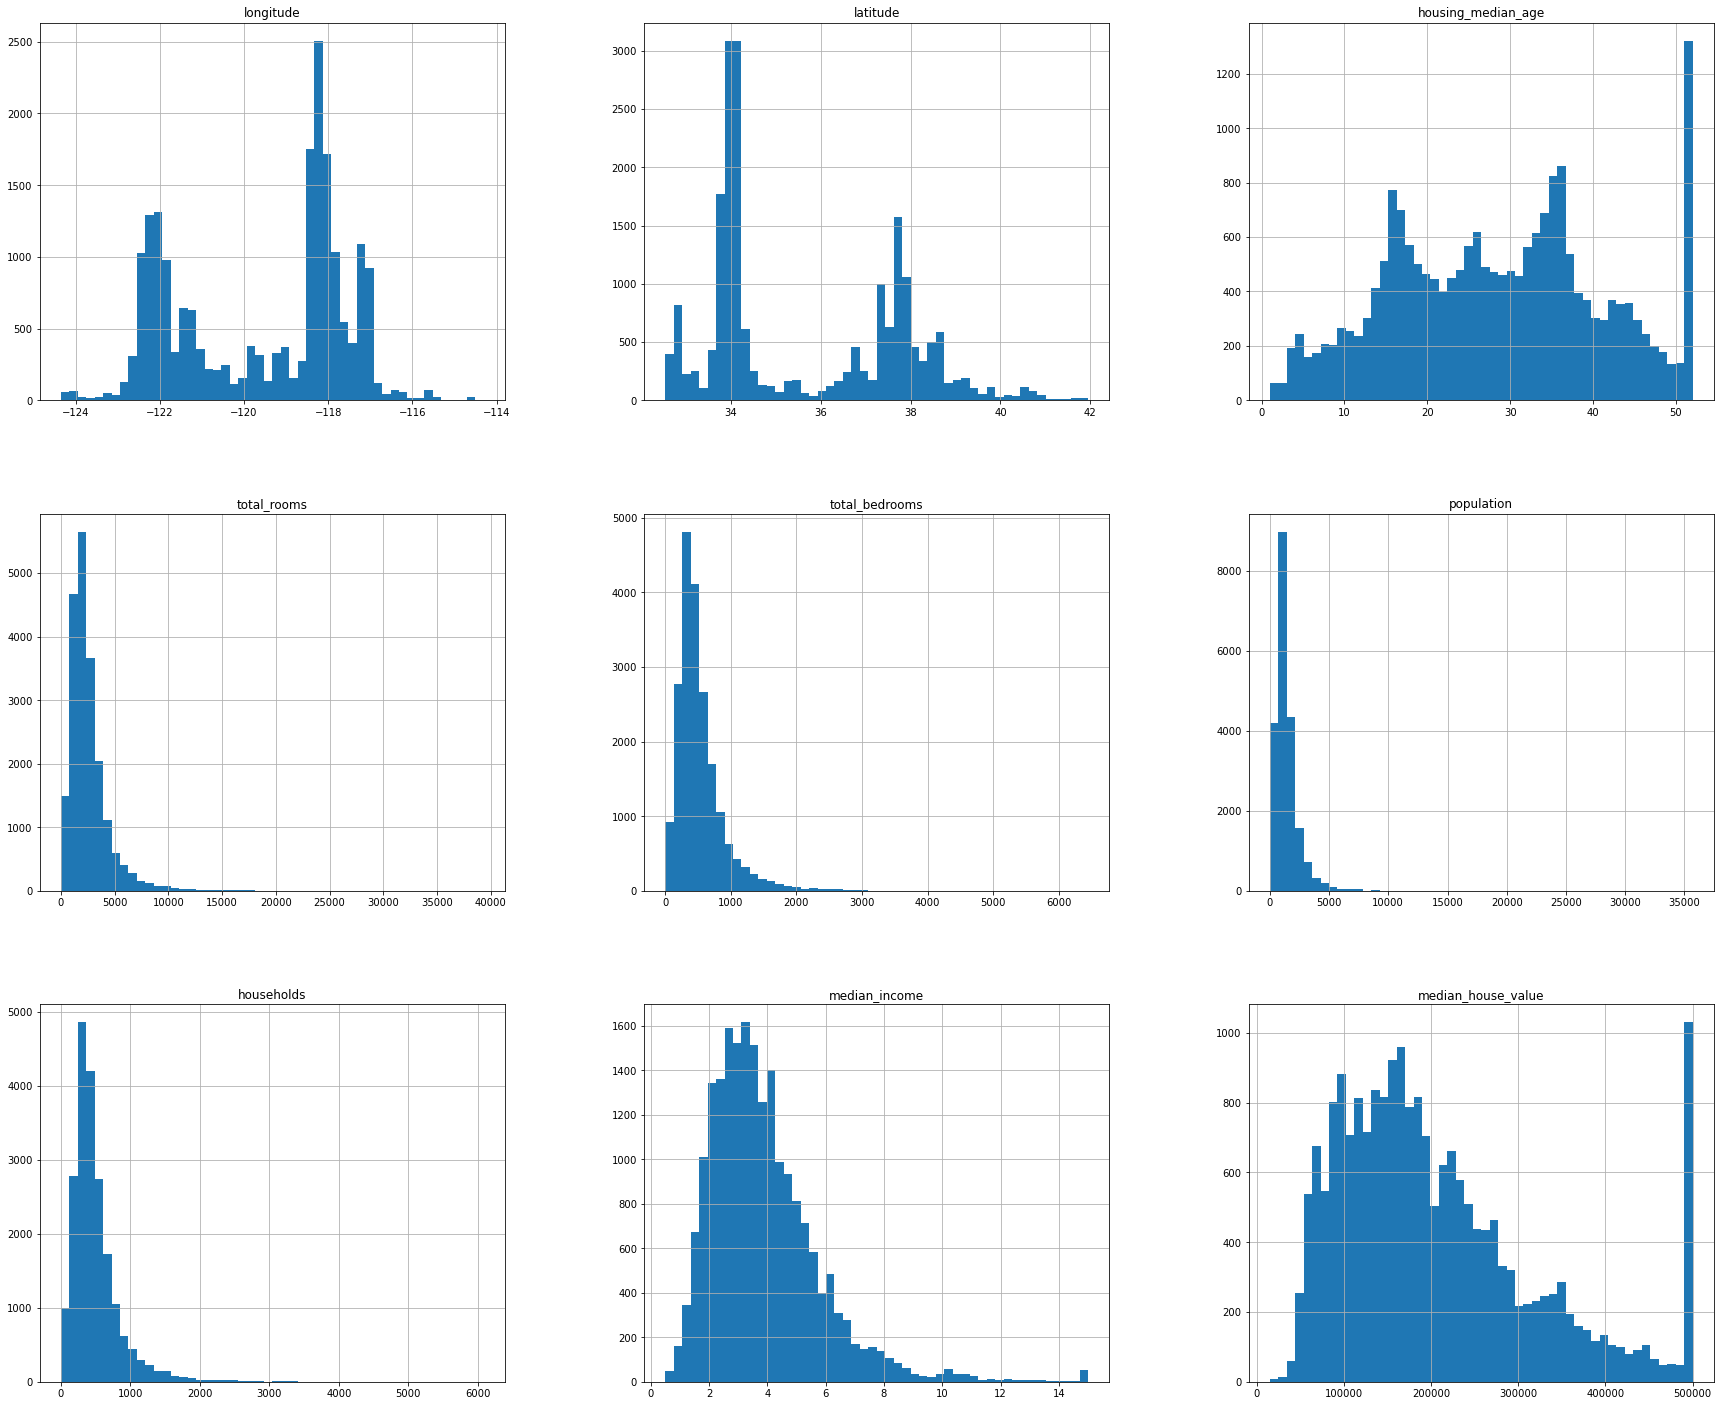

In [10]:
%matplotlib inline
housing.hist(bins=50, figsize=(30,25))
plt.show()

We can se a few outliers in housing_median_age and median_house_value

## Create a Train and Test set

To have proportional amounts of data per category in the train and test samples we need to normalize the data in 5 categories. If we take a look to the the histograms above, we can realize that the `median_income` is disproportionate, therefore we are going to have random tests samples if we run functions like `train_test_split` or `split_train_test`.

In [11]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [12]:
housing[["income_cat","median_income"]].head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
income_cat,5.0000,5.0000,5.0000,4.0000,3.0000,3.0000,3.0000,3.00,2.0000,3.0000,3.0000,3.0000,3.000,2.0000,2.0000
median_income,8.3252,8.3014,7.2574,5.6431,3.8462,4.0368,3.6591,3.12,2.0804,3.6912,3.2031,3.2705,3.075,2.6736,1.9167


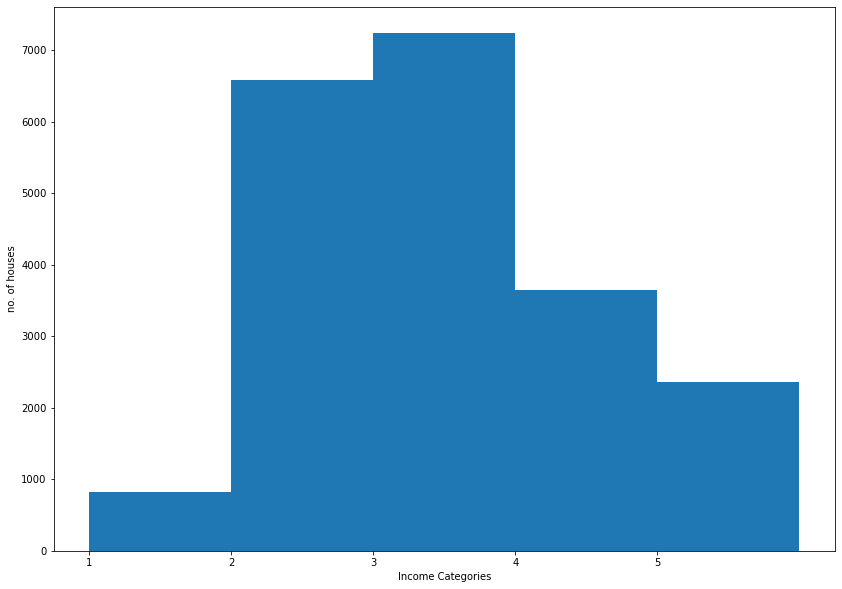

In [13]:
fig,ax = plt.subplots(1,1, figsize=(14,10))

ax.set_xticks([1,2,3,4,5])
ax.set_xlabel('Income Categories')
ax.set_ylabel('no. of houses')
ax.hist(housing['income_cat'], bins=[1,2,3,4,5,6])
plt.show()
#housing['income_cat'].hist(bins=[1,2,3,4,5,6], figsize=(14,8));

The housing dataset does not have an identifier column. The simplest solution is to use the
row index as the ID, If you use the row index as a unique identifier, you need to make sure that new data gets appended to the
end of the dataset, and no row ever gets deleted. 

If this is not possible, then you can try to use the most
stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed
to be stable for a few million years, so you could combine them into an ID like so:

In [14]:
#Don't really needed
#housing_with_id = housing.copy()
#housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

Provides train/test indices to split data in train/test sets.

This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.

In [15]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

`random_state`: use a new random number generator seeded by the given integer. Using an int will produce the same results across different calls. However, it may be worthwhile checking that your results are stable across a number of different distinct random seeds. Popular integer random seeds are 0 and 42. (See https://en.wikipedia.org/wiki/Phrases_from_The_Hitchhiker%27s_Guide_to_the_Galaxy#The_Answer_to_the_Ultimate_Question_of_Life,_the_Universe,_and_Everything_is_42)

We can now check if this worked as we expected.

#### Percentage of each category
As we can see after spliting wtih Stratified Shuffle Split, the percentages of each category are similar

In [16]:
strat_perc = pd.concat({
    'original':(housing["income_cat"].value_counts() / len(housing)),
    'train_set':(strat_train_set["income_cat"].value_counts() / len(strat_train_set)),
    'test_set':(strat_test_set["income_cat"].value_counts() / len(strat_test_set)),
}, axis=1)

In [17]:
(strat_perc.sort_index(ascending=True)
    .round({'original':4,'train_set':4,'test_set':4})
    .head())

,original,train_set,test_set
1.0,0.0398,0.0398,0.0397
2.0,0.3188,0.3189,0.3188
3.0,0.3506,0.3506,0.3505
4.0,0.1763,0.1763,0.1764
5.0,0.1144,0.1144,0.1146


Remove the `income_cat` attribute to get back to the original dataset

In [18]:
#strat_test_set = strat_test_set.drop("income_cat", axis=1, inplace=True)
#strat_train_set = strat_train_set.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

Let's make a copy of the dataset, so we can't harm the dataset

In [19]:
housing_train = strat_train_set.copy()

Now, let's see the dataset as geographical data, like a scatterplot, for easier visualising the data

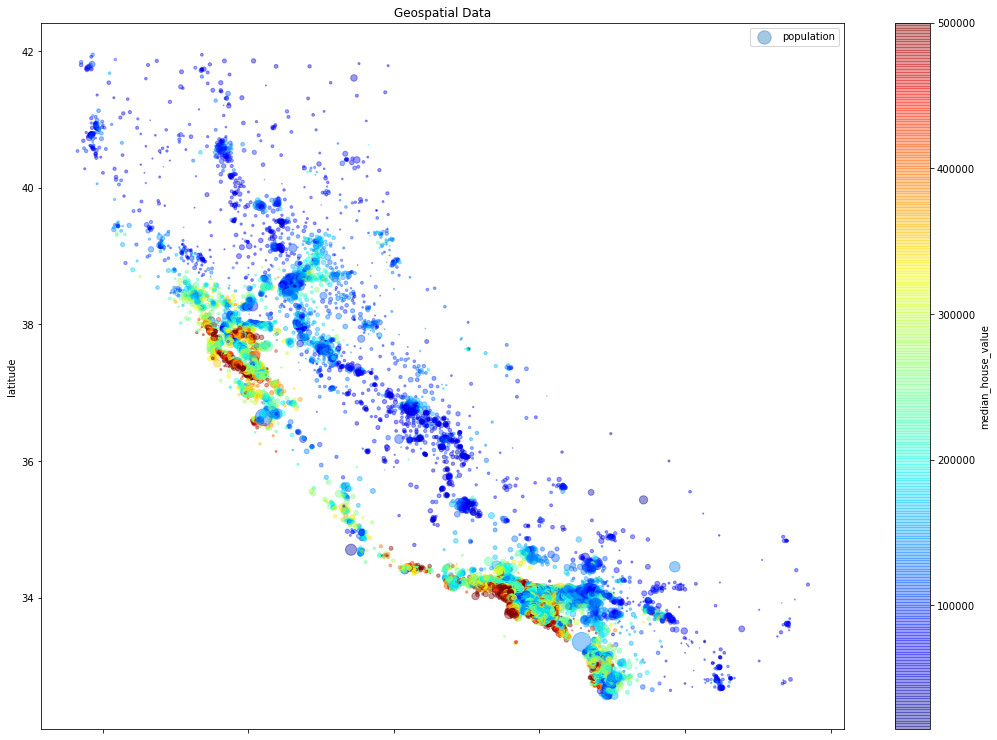

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(18,13),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.title('Geospatial Data');

Let's see how the correlation coefficients proceed here by creating a correlation matrix, with which you can see how important all the attributes are for the median house value.

In [21]:
corr_matrix = housing_train.corr()

In [22]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
income_cat            0.642274
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

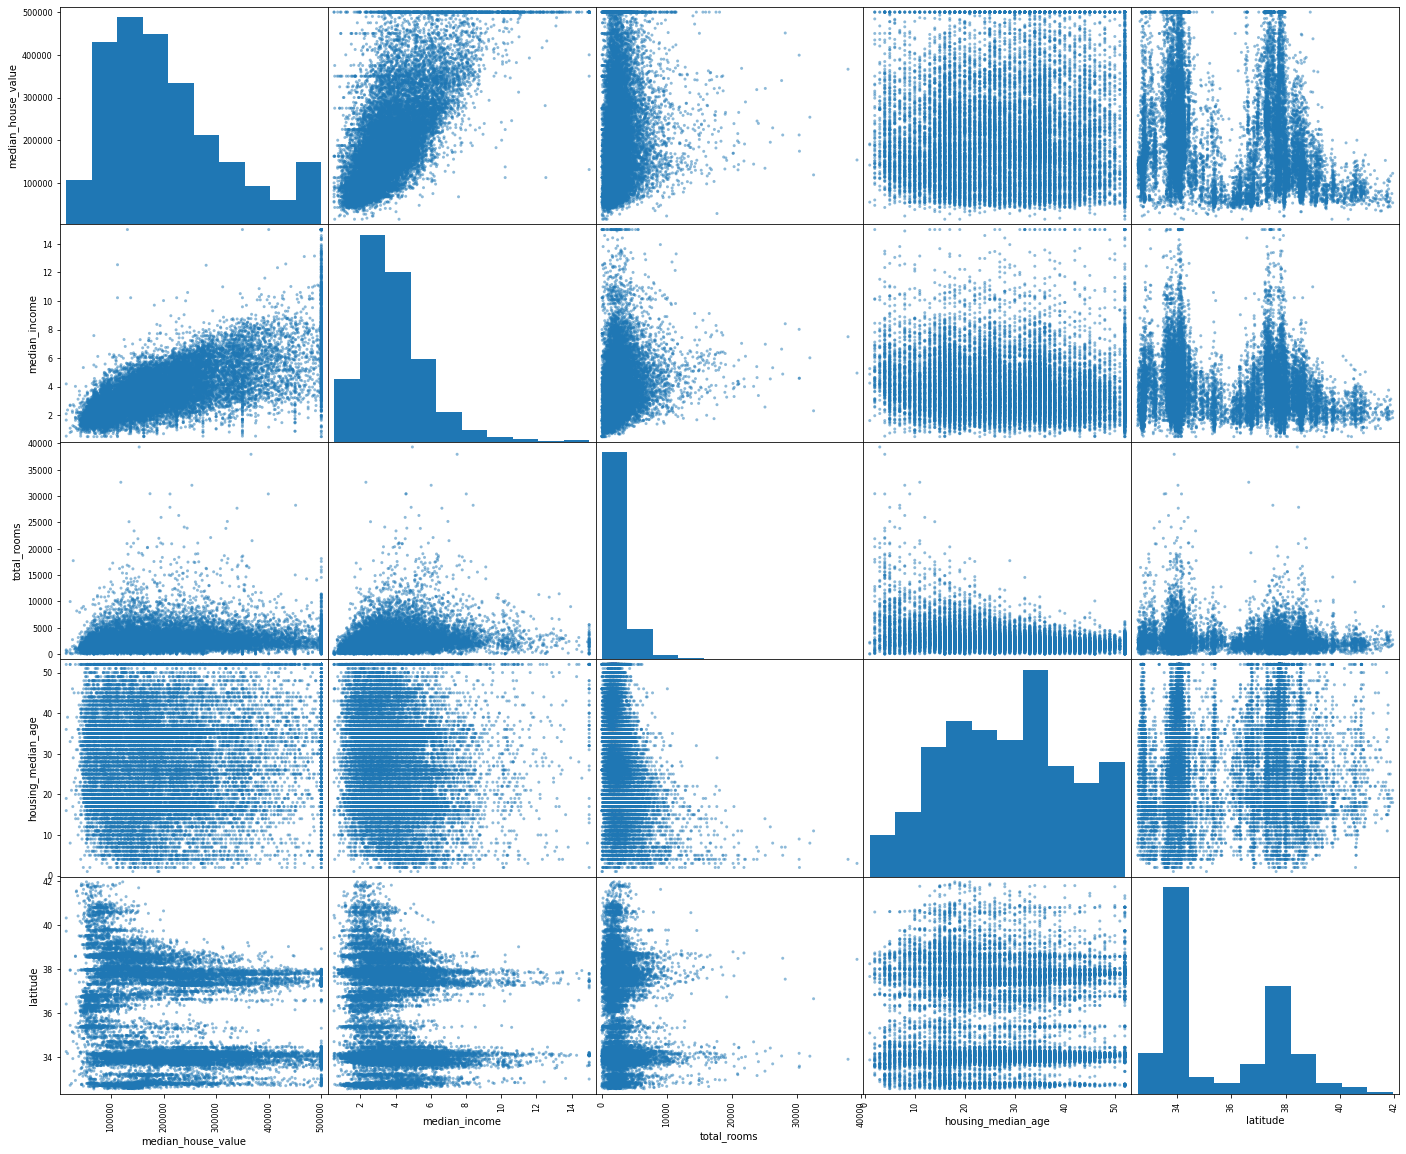

In [23]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age",'latitude']
scatter_matrix(housing[attributes], figsize=(24, 20));

We can now combine different attributes together (We can observe the graphicals and the histograms and make new attributes or even think about better correlations than the current and also make new attributes).

In [24]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [25]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

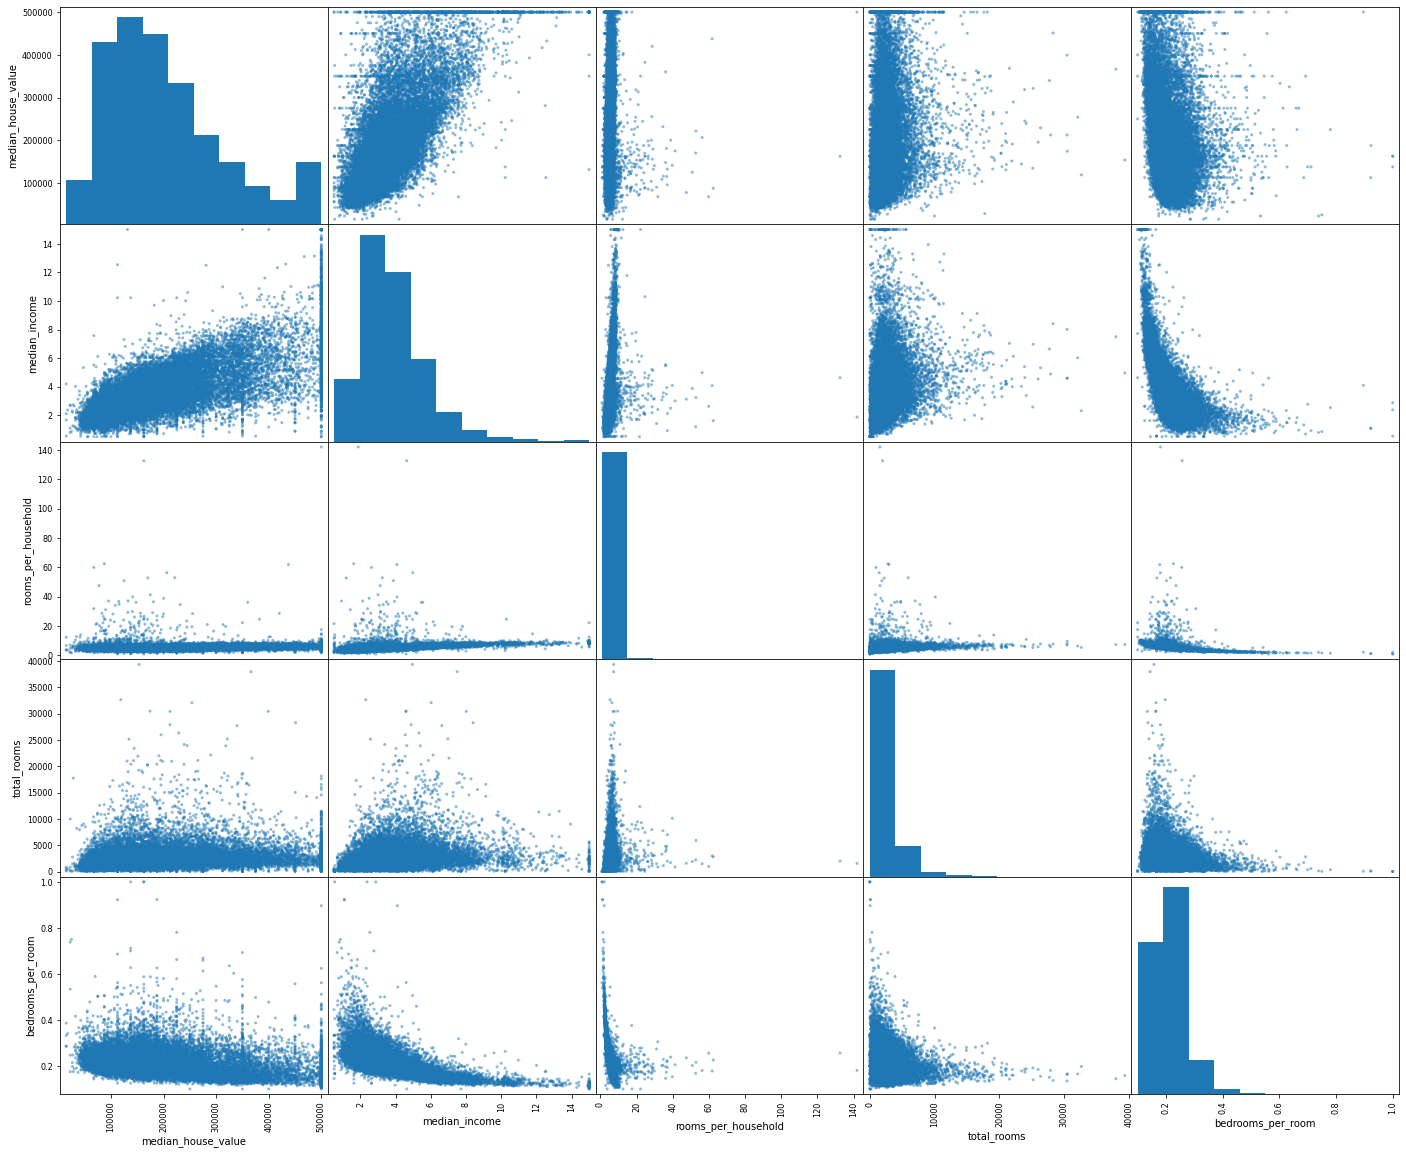

In [26]:
attributes = ["median_house_value", "median_income", "rooms_per_household", "total_rooms", "bedrooms_per_room"]
scatter_matrix(housing[attributes], figsize=(24, 20));

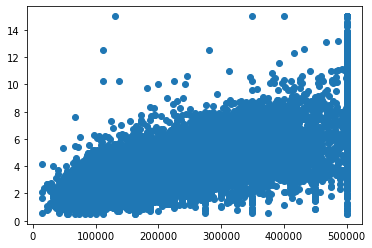

In [28]:
plt.scatter(housing['median_house_value'], housing['median_income'], alpha=1);

# Prepare the Data for Machine Learning Algorithms

Let’s revert to a clean training set (by copying strat_train_set), and let’s separate
the predictors and the labels since we don’t necessarily want to apply the same transformations to the
predictors and the target values.

In [18]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

We need to fix the `total_bedrooms` attribute, because as some missing values.
First let's set 

In [19]:
median = housing["total_bedrooms"].median()

In [20]:
housing["total_bedrooms"].fillna(median, inplace=True)

We will use Imputer to care about the missing values by writting several lines of code in which we are going to use an Imputer object for that purpose.

In [21]:
imputer = Imputer(strategy="median")

In [22]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [23]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

For ensure that we don't miss any attribute we can execute the two lines below and the results

In [24]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [25]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now we can use this to rebuild the dataset with complete data.

In [26]:
X = imputer.transform(housing_num)

We can put it in a Pandas dataframe for data management purposes

In [27]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

## Handling Text and Categorical Attributes

This line below is used for mapping labels into numerical, because of the machine learning model understands this better.

We decided tu use this type of encoder because is a simple one and for this project it doesn't make so much different between the rest.

It start encoding each label in order from 0 to n.

In [28]:
encoder = LabelBinarizer()
housing_cat = housing["ocean_proximity"]
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

## Custom transformers

We need now to rewrite many transformers for sklearn pipelines purposes that we are going to use afterwards.
This class is used for combine attributes automatically.

In [29]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
    
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Transformation Pipelines

We are going to create now pipelines, which are needed for automaing purposes. 
Firstly, we would want to create a transofrmer to directly introduce a Pandas dataframe into our pipeline.

In [30]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values



The Problem is that te pipeline is assuming LabelBinarizer's fit_transform method is defined to take three positional arguments:

    def fit_transform(self, x, y)
        ...rest of the code

while it is defined to take only two:

    def fit_transform(self, x):
        ...rest of the code

A  posible solution is making a custom transformer that can handle 3 positional arguments:

In [31]:
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

Secondly, we have to create the pipelines but now assuming that several transformers are going to be atuomaticlly feeded with the output of the previous transformer.
<br>Then we use `num_pipeline`, which is going to manage numerical attributes and "clean" them up, and further, we create another pipeline called `cat_pipeline` for categorical attributes. 

In [32]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', MyLabelBinarizer()),
    ])

Here we just join the two pipelines and invoke it

In [33]:
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [34]:
housing_prepared = full_pipeline.fit_transform(housing)

Now you can visualise the data.

In [35]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [36]:
housing_prepared.shape

(16512, 16)

## Select and Train a Model

In this part, we have to choose a model for it with our dataset and then predict housing prices.
But before that, we have to be sure that our model is in some way the best.

We had a shortlist of three regression models for this project which were **LinearRegression**, **DecisionTree** and **RandomForestRegresor**.

We have choosen **RandomForestRegresor** because is in which we obtained the less score by displying the scores of the three models.

An approximate mean score amount of each model is: 

LinearRegression: 68500
<br>DecisionTree: 71500
<br>RandomForestRegresor: **52000** 

In [37]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

We fit our model to the dataset and make predictions.

In [38]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)

We try to calculate the rmse error function (`mean_squared_error`)

In [39]:
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

Then scores for observe how is this model (We showed before that is aproximatly 52000)

In [40]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

In [41]:
forest_rmse
display_scores(forest_rmse_scores)

Scores: [49117.6119177  47804.25313034 49897.25850756 52427.59221711
 49516.76600794 53415.92161506 48850.30584396 47739.20668526
 52878.27627551 50331.13752964]
Mean: 50197.83297300905
Standard deviation: 1945.287613581183


# Fine-Tune the Model

This is good to finish improve the way the model fit to the data.
<br>The following code
searches for the best combination of hyperparameter values for the RandomForestRegressor

In [42]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                            scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

Searching for the best params

In [43]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [44]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

## Analizing the Model and Errors 

You can see an array with the importance scores of each attribute:

In [45]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.95569443e-02, 6.14117814e-02, 4.38153256e-02, 1.50977304e-02,
       1.45596262e-02, 1.48550529e-02, 1.45165899e-02, 3.87904501e-01,
       4.23318004e-02, 1.12612666e-01, 6.75607260e-02, 1.40864526e-02,
       1.33598614e-01, 8.56434350e-05, 4.37905615e-03, 3.62748961e-03])

An then see these importance scores next to their corresponding attribute names:

In [46]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.38790450139863164, 'median_income'),
 (0.13359861372287432, 'INLAND'),
 (0.11261266595283598, 'pop_per_hhold'),
 (0.06955694430134411, 'longitude'),
 (0.06756072597482303, 'bedrooms_per_room'),
 (0.061411781378672856, 'latitude'),
 (0.043815325568776646, 'housing_median_age'),
 (0.04233180037831895, 'rooms_per_hhold'),
 (0.015097730412769484, 'total_rooms'),
 (0.014855052929978994, 'population'),
 (0.014559626240793488, 'total_bedrooms'),
 (0.014516589909212925, 'households'),
 (0.014086452633829825, '<1H OCEAN'),
 (0.0043790561526762, 'NEAR BAY'),
 (0.0036274896094432778, 'NEAR OCEAN'),
 (8.564343501819296e-05, 'ISLAND')]

## Evaluationg of Test Set

Get the predictors and the labels from the test set, run the full_pipeline to transform the data and evaluate the final model on the test set:

In [47]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [48]:
final_predictions = final_model.predict(X_test_prepared)

In [49]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

To see the final RMSE use the line below

In [50]:
final_rmse

47667.27210822335

CSV export

In [51]:
array_id = list(range(4128))
final_df = pd.DataFrame({'Id': array_id, 'median_house_value': final_predictions})
final_df.set_index('Id',inplace=True)

final_df.to_csv('housing_predictions.csv')